## Generate predictions from h5 of CNN model

The purpose of this program is to generate files containing the predictions in training, test and validation from a h5 model


In [1]:
import os


PATH = "resultsFirstRound/"

models_files_ids = [each.replace("_model.h5", "") for each in os.listdir(PATH) if each.endswith('_model.h5')]


model_file_id = "1583899373967985_inceptionresnetv2"

models_files_ids



['1583899373967985_inceptionresnetv2',
 '15837357948682456_vgg19',
 '15838869227308767_vgg19',
 '15837959273993561_vgg19',
 '1583742615626935_inceptionresnetv2',
 '1583774484627341_inceptionresnetv2',
 '15839166853657446_inceptionv3',
 '15837597401511614_vgg19',
 '1583753261050332_inceptionv3',
 '15837861252003317_inceptionv3']

In [2]:
from tensorflow.keras.applications.vgg19 import VGG19
from Model import *
from Utils import *
import numpy as np
import pandas as pd
import os
import copy
import pickle
from sklearn.preprocessing import LabelBinarizer, scale
import warnings
warnings.filterwarnings('ignore')

PATH = "resultsFirstRound/"
include_ceilometer = True



print(model_file_id)

##############################################################
# Loading indices
##############################################################
indices_file = ("%s_indices.pickle" % model_file_id)
with open(os.path.join(PATH,indices_file), 'rb') as f:
    indices = pickle.load(f)
in_train, in_valid, in_test = indices

##############################################################
# Loading features
##############################################################
data = pd.read_csv("data/cloud_features.csv", sep=';', decimal=',')

img_file='images.npz'
file_dir = "data/"
images = np.load('%s/%s' % (file_dir, img_file), 'r', True)['arr_0']
# train_data = data['train']
img_train, img_test, img_valid = images[in_train].astype('float32'), images[in_test].astype('float32'), images[in_valid].astype('float32')

# Ceil
ceil_info = np.array(data[["ceil.height0", "ceil.height1", "ceil.height2", "ceil.depth0",
                           "ceil.depth1", "ceil.depth2","ceil.layers"]])
ceil_info = scale(ceil_info, copy=False)
ceil_train, ceil_test, ceil_valid = ceil_info[in_train], ceil_info[in_test], ceil_info[in_valid]

# Obtaining y vector
cloud_type = np.array(data['cloud.type'])
encoder = LabelBinarizer()
cloud_encoded = encoder.fit_transform(cloud_type)
y_train, y_test, y_valid = cloud_encoded[in_train], cloud_encoded[in_test], cloud_encoded[in_valid]

##############################################################
# Loading model
##############################################################
model = load_model(os.path.join(PATH, "%s_model.h5" % model_file_id))






/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

1583899373967985_inceptionresnetv2
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
def generate_classification_report(file_dir, model_file_name, model, encoder, img_set, ceil_set, 
                                   y_set, data_generator, include_ceilometer, n_outputs, set_name):


    print("Getting classification report of %s set..." % set_name)
    
    

    # Extraer las predicciones del modelo
    x_set = data_generator.standardize(copy.deepcopy(img_set))
      
    if include_ceilometer:
        x_set = [x_set, ceil_set]
        
    decod_predictions_set = encoder.inverse_transform(model.predict(x_set))

    decoded_observations = encoder.inverse_transform(y_set)
                                                     
    pred_obs = pd.DataFrame(data={'pred': decod_predictions_set, 'obs': decoded_observations})
    
    # pred_obs_train.to_csv(os.path.join("testing", '%s_train_preds.csv' % model_file_id), index=False)

    
    # Evaluar el Modelo
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    matrix = confusion_matrix(pred_obs['obs'], pred_obs['pred'])
    names = pred_obs['obs'].unique()

    sns.heatmap(matrix, annot=True, cbar=False, xticklabels=names, yticklabels=names)
    classification_report_matrix = classification_report(pred_obs['obs'], pred_obs['pred'], output_dict=True)
    #print(classification_report_matrix)
    
    print(str(pred_obs['obs'][:10]))

    
    classification_dict = {k: classification_report_matrix[k] for k in ('accuracy', 'macro avg', 'weighted avg')}

    summary_dict = {}

    for x in classification_dict.keys():
        if isinstance(classification_dict[x], dict):
            for x2 in list(classification_dict[x].keys()):           
                summary_dict[x.replace(" ", "_") + "-" + x2] = classification_dict[x][x2]
        else:
            summary_dict[x] = classification_dict[x]
        
    # print(str())
                
    with open('%s/%s' % (PATH, model_file_name.replace("_model.h5", '_%s_summary_acc.csv' % set_name )),'w') as f:
        w = csv.writer(f)
        w.writerow(summary_dict.keys())
        w.writerow(summary_dict.values())

    with open('%s/%s' % (PATH, ("%s_%s_classification_report.txt" % (set_name, model_file_name.replace("_model.h5", "")))), "w") as outputfile:
        outputfile.write(str(classification_report(pred_obs['obs'], pred_obs['pred'])))

    # Almacenar las predicciones del modelo entrenado
    pred_obs.to_csv('%s/%s' % (PATH, model_file_name.replace("_model.h5", '_%s_preds.csv' % set_name)))


generatin...
Getting classification report of train set...
0       altostratos
1      cirrocumulos
2            cirros
3    estratocumulos
4         multinube
5            cirros
6    estratocumulos
7          estratos
8         multinube
9           cumulos
Name: obs, dtype: object
Getting classification report of test set...
0       altocumulos
1         multinube
2    estratocumulos
3         multinube
4          estratos
5       altocumulos
6            cirros
7    estratocumulos
8    estratocumulos
9       altocumulos
Name: obs, dtype: object
Getting classification report of valid set...
0            cirros
1    estratocumulos
2         multinube
3          estratos
4    estratocumulos
5      cirrostratos
6            cirros
7         multinube
8       altostratos
9           cumulos
Name: obs, dtype: object


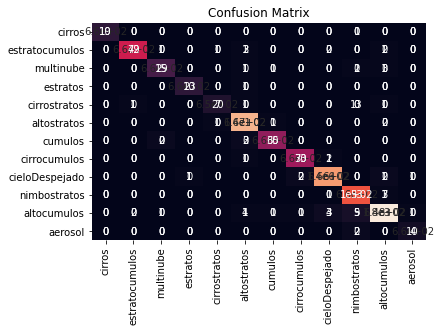

In [4]:
##############################################################
# Data generator
##############################################################
data_generator = make_data_generator((img_train.astype('float32'), ceil_train, y_train))


model_file_name = "%s_model.h5" % model_file_id

print("generatin...")


generate_classification_report(file_dir, model_file_name, model, encoder, img_train, 
                               ceil_train, y_train, data_generator, include_ceilometer, 1, "train")

generate_classification_report(file_dir, model_file_name, model, encoder, img_test, 
                               ceil_test, y_test, data_generator, include_ceilometer, 1, "test")

generate_classification_report(file_dir, model_file_name, model, encoder, img_valid, 
                               ceil_valid, y_valid, data_generator, include_ceilometer, 1, "valid")

In [ ]:
"""
data_generator = make_data_generator((img_train.astype('float32'), ceil_train, y_train))

print("FINISHED")
"""


In [ ]:
"""
x_train = data_generator.standardize(copy.deepcopy(img_train))
x_test = data_generator.standardize(copy.deepcopy(img_test))
x_valid = data_generator.standardize(copy.deepcopy(img_valid))


if include_ceilometer:
    x_train = [x_train, ceil_train]
    x_test = [x_test, ceil_test]
    x_valid = [x_valid, ceil_valid]
    
print(x_train)
    

##############################################################
# Obtaining predictions
##############################################################
decod_predictions_train = encoder.inverse_transform(model.predict(x_train))
decod_predictions_test = encoder.inverse_transform(model.predict(x_test))
decod_predictions_valid = encoder.inverse_transform(model.predict(x_valid))

decod_observations_train = encoder.inverse_transform(y_train)
decod_observations_test = encoder.inverse_transform(y_test)
decod_observations_valid = encoder.inverse_transform(y_valid)

pred_obs_train = pd.DataFrame(data={'pred': decod_predictions_train, 'obs': decod_observations_train})
pred_obs_test = pd.DataFrame(data={'pred': decod_predictions_test, 'obs': decod_observations_test})
pred_obs_valid = pd.DataFrame(data={'pred': decod_predictions_valid, 'obs': decod_observations_valid})

print("Training...")
pred_obs_train.to_csv(os.path.join("testing", '%s_train_preds.csv' % model_file_id), index=False)
"""